# Chapter 7: n step methods

### N step TD methods
### Exercise 7.2

In [34]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tqdm

In [2]:
n_states=19
true_values=np.arange(-20,22,2)/20.0
true_values[0]=true_values[-1]=0
start_state=10
end_state=-1

In [26]:
true_values.shape

(21,)

In [ ]:
def n_step_td(values,n_states,n,alpha):
    t=0
    S_t=10 #Start state is 10
    T=np.infty
    R_i=dict()
    S_i={0:S_t}
    while True:
       #Take action
        if t<T:
            if random.random()<0.5:
                S_t_=S_t+1
            else:
                S_t_=S_t-1
            if S_t_==0:
                R_t_=-1
                T=t+1
            elif S_t_==n_states+1:
                R_t_=1
                T=t+1
            else:
                R_t_=0
            R_i[t+1]=R_t_
            S_i[t+1]=S_t_
            S_t=S_t_
        tau=t-n+1
        if tau>=0:
            G=sum([R_i[i] for i in range(tau+1,min(T,tau+n)+1)])
            if tau+n<T: G=G+values[S_i[tau+n]]
            values[S_i[tau]]=values[S_i[tau]]+alpha*(G-values[S_i[tau]])
        if tau==T-1:
            break
        t+=1

In [65]:
def sum_of_td_errors(values,n_states,n,alpha):
    t=0
    S_t=10 #Start state is 10
    T=np.infty
    R_i=dict()
    S_i={0:S_t}
    while True:
       #Take action
        if t<T:
            if random.random()<0.5:
                S_t_=S_t+1
            else:
                S_t_=S_t-1
            if S_t_==0:
                R_t_=-1
                T=t+1
            elif S_t_==n_states+1:
                R_t_=1
                T=t+1
            else:
                R_t_=0
            R_i[t+1]=R_t_
            S_i[t+1]=S_t_
            S_t=S_t_
            t+=1
        else:
            break
    #Calculate the n step error using sum of td errors
    for tau in range(0,T+1):
        deltas=[]
        for t in range(tau,min(tau+n,T)):
            deltas.append(R_i[t+1]+values[S_i[t+1]]-values[S_i[t]])
        values[S_i[tau]]=np.sum(deltas)
    

In [50]:

graphs_1=dict()
N_vals=[2**i for i in range(0,8)]
for n in tqdm.tqdm(N_vals):
    graphs_1[n]={'x':[],'y':[]}
    for alpha in np.arange(0,1.05,0.05):
        R_ms=[]
        for exp in range(100):
            values=np.zeros(true_values.shape)
            for eps in range(10):
                n_step_td(values,n_states,n,alpha) #Run for 10 episodes
            #Calculate the average error
            error=np.sqrt(np.sum((values-true_values)**2))
            R_ms.append(error)
        R_ms=np.mean(R_ms)
        graphs_1[n]['x'].append(alpha)
        graphs_1[n]['y'].append(R_ms)


100%|██████████| 8/8 [00:27<00:00,  3.49s/it]


In [80]:

graphs_2=dict()
N_vals=[2**i for i in range(0,8)]
for n in tqdm.tqdm(N_vals):
    graphs_2[n]={'x':[],'y':[]}
    for alpha in np.arange(0,1.05,0.05):
        R_ms=[]
        for exp in range(100):
            values=np.zeros(true_values.shape)
            for eps in range(10):
                sum_of_td_errors(values,n_states,n,alpha) #Run for 10 episodes
            #Calculate the average error
            error=np.sqrt(np.sum((values-true_values)**2))
            R_ms.append(error)
        R_ms=np.mean(R_ms)
        graphs_2[n]['x'].append(alpha)
        graphs_2[n]['y'].append(R_ms)


100%|██████████| 8/8 [02:31<00:00, 19.00s/it]


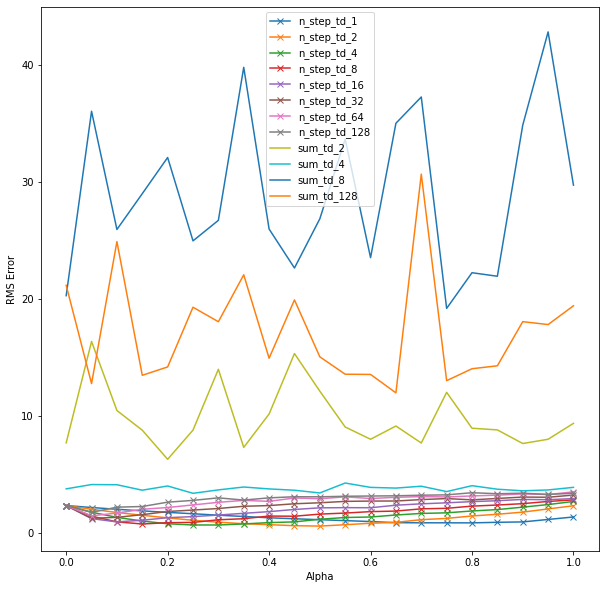

In [81]:
plt.figure(figsize=(10,10))
plt.xlabel('Alpha')
plt.ylabel('RMS Error')
for n, graph in graphs_1.items():
    plt.plot(graph['x'],graph['y'],label='n_step_td_'+str(n),marker='x')
for n, graph in graphs_2.items():
    if max(graph['y'])<100:
        plt.plot(graph['x'],graph['y'],label='sum_td_'+str(n))
plt.legend()
plt.show()

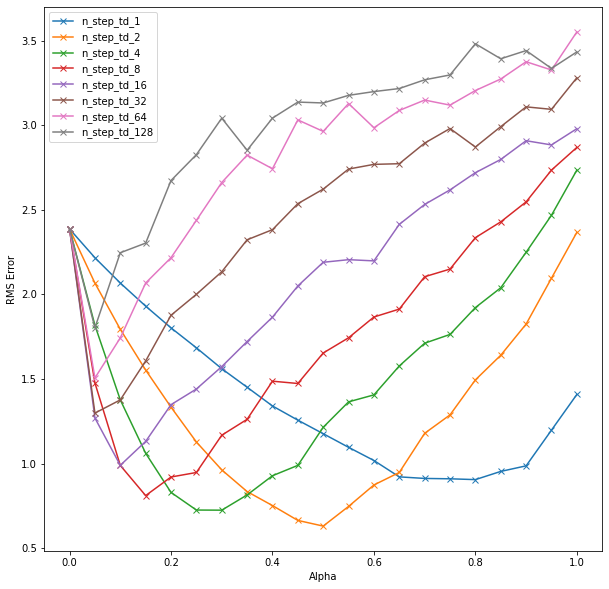

In [79]:
plt.figure(figsize=(10,10))
plt.xlabel('Alpha')
plt.ylabel('RMS Error')
for n, graph in graphs_1.items():
    plt.plot(graph['x'],graph['y'],label='n_step_td_'+str(n),marker='x')
plt.legend()
plt.show()

Conclusion: RMS Errors are much higher when using 10 episodes for sum of TD errors

## Exercise 7.10

We can devise a simply off policy prediction problem using the random walk prediction problem, we can use a policy pi that has a probability 0.5 selecting either a left or right action. The behaviorial policy used will have a probability 0.2 of selecting a right action and probability 0.8 of selecting a left action. 

We measure the average RMS over 100 independent runs and plot it with the number of episodes to demonstrate the data efficiency

In [146]:
def n_step_td_off_policy(values,n_states,n,alpha):
    t=0
    S_t=10 #Start state is 10
    T=np.infty
    R_i=dict()
    S_i={0:S_t}
    A_i=dict()
    while True:
       #Take action
        if t<T:
            #Use a behavioural policy b which has prob 0.2 of selecting 
            if random.random()<0.2: 
                S_t_=S_t+1
                A_t=1 #Right
            else:
                S_t_=S_t-1
                A_t=0
            if S_t_==0:
                R_t_=-1
                T=t+1
            elif S_t_==n_states+1:
                R_t_=1
                T=t+1
            else:
                R_t_=0
            R_i[t+1]=R_t_
            S_i[t+1]=S_t_
            A_i[t]=A_t
            S_t=S_t_
        tau=t-n+1
        if tau>=0:
            rho=[0.5/(0.2*A_i[i]+(1-A_i[i])*0.8) for i in range(tau,min(T,tau+n))]
            rho=np.prod(rho)
            G=sum([R_i[i] for i in range(tau+1,min(T,tau+n)+1)])
            if tau+n<T: G=G+values[S_i[tau+n]]
            values[S_i[tau]]=values[S_i[tau]]+alpha*rho*(G-values[S_i[tau]])
        if tau==T-1:
            break
        t+=1

In [158]:
def n_step_td_off_policy_per_decision_control_variate(values,n_states,n,alpha):
    t=0
    S_t=10 #Start state is 10
    T=np.infty
    R_i=dict()
    S_i={0:S_t}
    A_i=dict()
    while True:
       #Take action
        if t<T:
            #Use a behavioural policy b which has prob 0.2 of selecting 
            if random.random()<0.2: 
                S_t_=S_t+1
                A_t=1 #Right
            else:
                S_t_=S_t-1
                A_t=0 #Left
            if S_t_==0:
                R_t_=-1
                T=t+1
            elif S_t_==n_states+1:
                R_t_=1
                T=t+1
            else:
                R_t_=0
            R_i[t+1]=R_t_
            S_i[t+1]=S_t_
            A_i[t]=A_t
            S_t=S_t_
        tau=t-n+1
        if tau>=0:
            if tau+n<T: G=values[S_i[tau+n]]
            else:
                G=0
            for i in range(min(tau+n-1,T-1),tau-1,-1): #From tau+n-1 T-1 to tau
                rho=0.5/(0.2*A_i[i]+(1-A_i[i])*0.8)
                G=rho*(R_i[i+1]+G)+(1-rho)*values[S_i[i]]
            values[S_i[tau]]=values[S_i[tau]]+alpha*(G-values[S_i[tau]])
        if tau==T-1:
            break
        t+=1

In [177]:

graphs_1=dict()
N_vals=[i for i in range(1,4)]
for n in tqdm.tqdm(N_vals):
    graphs_1[n]={'x':[],'y':[]}
    for alpha in np.arange(0,0.8,0.05):
        R_ms=[]
        for exp in range(100):
            values=np.zeros(true_values.shape)
            for eps in range(10):
                n_step_td_off_policy(values,n_states,n,alpha) #Run for 10 episodes
            #Calculate the average error
            error=np.sqrt(np.sum((values-true_values)**2))
            R_ms.append(error)
        R_ms=np.mean(R_ms)
        graphs_1[n]['x'].append(alpha)
        graphs_1[n]['y'].append(R_ms)


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


In [187]:

graphs_2=dict()
N_vals=[i for i in range(1,4)]
for n in tqdm.tqdm(N_vals):
    graphs_2[n]={'x':[],'y':[]}
    for alpha in np.arange(0,0.8,0.05):
        R_ms=[]
        for exp in range(100):
            values=np.zeros(true_values.shape)
            for eps in range(10):
                n_step_td_off_policy_per_decision_control_variate(values,n_states,n,alpha) #Run for 10 episodes
            #Calculate the average error
            error=np.sqrt(np.sum((values-true_values)**2))
            R_ms.append(error)
        R_ms=np.mean(R_ms)
        graphs_2[n]['x'].append(alpha)
        graphs_2[n]['y'].append(R_ms)


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


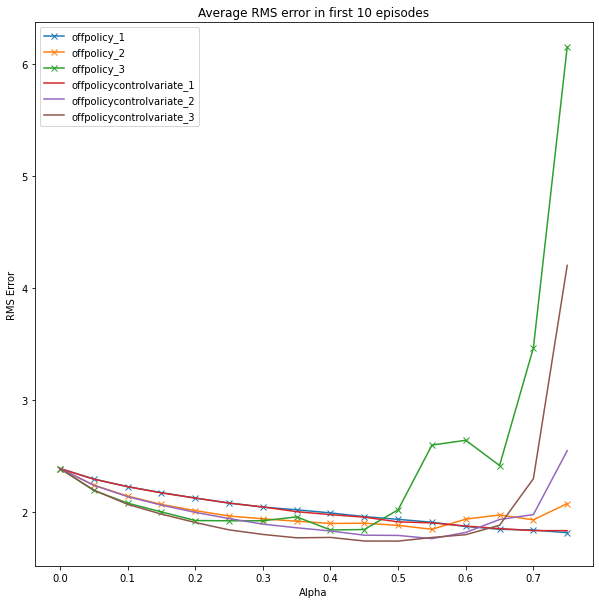

In [188]:
plt.figure(figsize=(10,10))
plt.xlabel('Alpha')
plt.ylabel('RMS Error')
for n, graph in graphs_1.items():
    plt.plot(graph['x'],graph['y'],label='offpolicy_'+str(n),marker='x')
for n, graph in graphs_2.items():
    plt.plot(graph['x'],graph['y'],label='offpolicycontrolvariate_'+str(n))
plt.legend()
plt.title("Average RMS error in first 10 episodes")
plt.show()

Across most alpha and N values the control variate per decision sampling method results in lower RMS values during the first 10 episodes,  hence more data efficient. Furthermore for higher step sizes, the simpler method has higher variance hence high RMS values. RMS values for the per decision sampling control variate method are much more stable. 